In [1]:
import tensorflow as tf
import keras
import os

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [4]:
PATH = './images/train'
CLASS_NAMES = ['no', 'thankyou', 'yes'] #'fine', 'hello', 
BATCH_SIZE = 32
print(os.listdir(PATH))

['no', 'thankyou', 'yes']


Preprocessing Images

In [6]:
# Define input directory
input_dir_train = 'images/train'
input_dir_test = 'images/test'

# Define batch size and image size
batch_size = 32
image_size = (180, 180)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    input_dir_train,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

# Create test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    input_dir_test,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,    
)

print("Datasets created successfully.")

Found 72 files belonging to 3 classes.


Found 18 files belonging to 3 classes.
Datasets created successfully.


In [7]:
os.listdir(input_dir_test)

['no', 'thankyou', 'yes']

In [8]:
for images, labels in train_dataset.take(1):
    print(labels)

tf.Tensor(
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]], shape=(32, 3), dtype=float32)


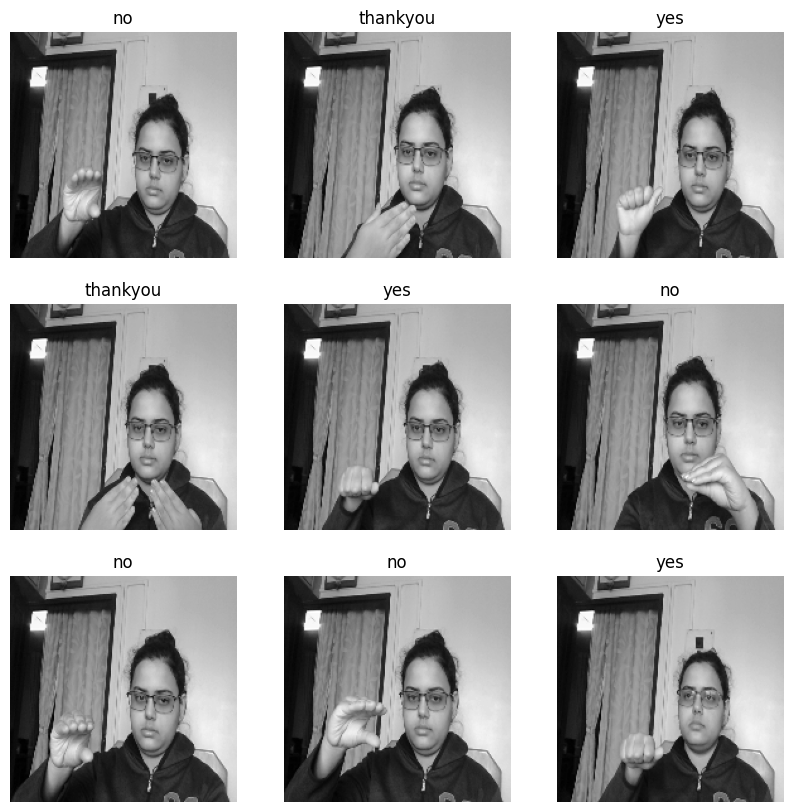

In [9]:
import matplotlib.pyplot as plt

class_names = ['no', 'thankyou', 'yes'] #'fine', 'hello', 
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):  # Assuming you want to visualize from the train_dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze().astype("uint8"), cmap='gray')  # Squeeze to remove the single-channel dimension
        plt.title(class_names[tf.argmax(labels[i]).numpy()])  # Assuming labels are one-hot encoded
        plt.axis("off")
plt.show()


Model Creation


In [10]:
# Define input shape
image_height, image_width = 180, 180
num_classes = 3

# Define the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

d:\Projects\TFODCourse\tfod\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,646,787 (25.36 MB)

 Trainable params: 6,646,787 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Define callbacks for early stopping and learning rate reduction
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Fit the model with callbacks
epochs = 10
history = model.fit(
    train_dataset,
    # validation_data=test_dataset,
    epochs=epochs,
    # callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.9015 - loss: 0.2847
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 0.9201 - loss: 0.2437
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.8958 - loss: 0.1569
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.8681 - loss: 0.1862
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - accuracy: 0.9301 - loss: 0.1495
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.8928 - loss: 0.3151
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.9262 - loss: 0.1174
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - accuracy: 0.9627 - loss: 0.1025
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.9627 - loss: 0.0782
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9449 - loss: 0.1319


In [23]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")
print("Test Accuracy:", test_accuracy)

print("Model trained and evaluated successfully.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step - accuracy: 0.8889 - loss: 0.5548
Test accuracy: 0.8888888955116272
Test Accuracy: 0.8888888955116272
Model trained and evaluated successfully.


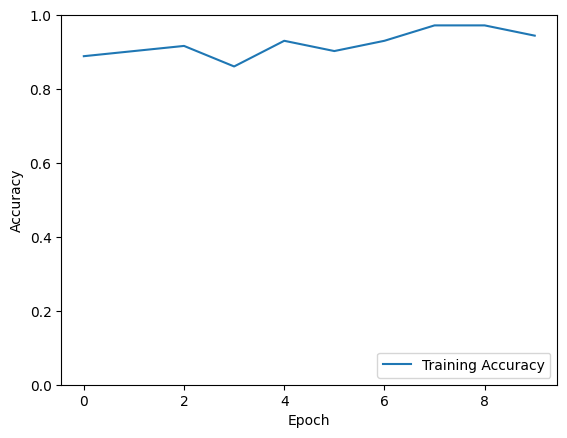

In [24]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

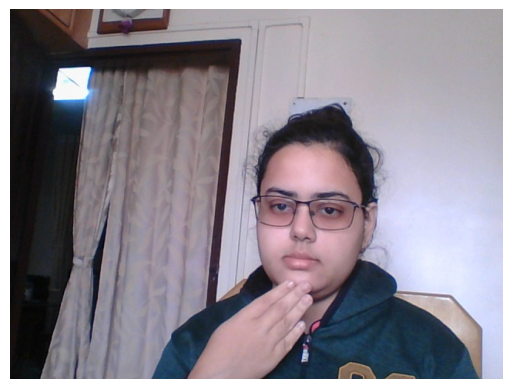

In [17]:
import numpy as np
import matplotlib.pyplot as plt

test_image_path = 'images/test/thankyou/thankyou.5815b00a-bb53-11ee-9b05-2cdb079ec43c.jpg'
# Load the test image
test_image = plt.imread(test_image_path)

# Display the test image
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [18]:
# Resize the test image if necessary (assuming 'image_size' is the desired size)
image_size=[180, 180]
if test_image.shape[:2] != image_size:
    test_image = tf.image.resize(test_image, image_size)
# Convert the resized image to grayscale
test_image_gray = tf.image.rgb_to_grayscale(test_image)
test_image_gray = tf.expand_dims(test_image_gray, axis=0)  # Add batch dimension


In [19]:
# Predict the class of the test image using the trained model
predictions = model.predict(test_image_gray)

# Convert predictions to numpy array
predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


In [20]:
predictions

array([[0.09901001, 0.88169396, 0.01929607]], dtype=float32)

In [21]:
# Find the index of the maximum value in the array
predicted_class_index = np.argmax(predictions)

# Output the predicted class index
print("Predicted class index:", predicted_class_index)

# Output the predicted class label
class_names = ['no', 'thankyou', 'yes'] #'fine', 'hello', 
predicted_class_label = class_names[predicted_class_index]
print("Predicted class is:", predicted_class_label)

Predicted class index: 1
Predicted class is: thankyou


In [25]:
model.save('cnn_Ananki_acc95_testac89_gray.h5')

In [26]:
model.save('cnn_Ananki_acc95_testac89_gray.keras')